In [10]:
# --- A) IMPORT LIBRARIES ---
import os
import json
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from rasterio.mask import mask
from rasterio.features import rasterize
from shapely.geometry import mapping,box
# --- B) FUNCTIONS ---
from functions import *
import matplotlib.pyplot as plt
import functions
import importlib
importlib.reload(functions)



<module 'functions' from '/Users/amirdonyadide/Documents/GitHub/LayerAlterator/functions.py'>

In [2]:
# Function 1 : load_vector_mask

# Test paths
gpkg_path = "test_data/fun_1/test_mask.gpkg"
geojson_path = "test_data/fun_1/test_mask.geojson"
shp_path = "test_data/fun_1/test_mask.shp"
invalid_path = "test_data/fun_1/test_mask.csv"

# --- Test 1: GPKG with layer name ---
print("\n--- Test 1: GPKG with layer name ---")
try:
    gdf = load_vector_mask(gpkg_path, layer_name="vector_mask_milan")
    print("GPKG load successful:", len(gdf), "features")
except Exception as e:
    print("GPKG test failed:", e)

# --- Test 2: GeoJSON ---
print("\n--- Test 2: GeoJSON ---")
try:
    gdf = load_vector_mask(geojson_path)
    print("GeoJSON load successful:", len(gdf), "features")
except Exception as e:
    print("GeoJSON test failed:", e)

# --- Test 3: Shapefile ---
print("\n--- Test 3: Shapefile ---")
try:
    gdf = load_vector_mask(shp_path)
    print("Shapefile load successful:", len(gdf), "features")
except Exception as e:
    print("Shapefile test failed:", e)

# --- Test 4: Unsupported format ---
print("\n--- Test 4: Invalid format (CSV) ---")
try:
    gdf = load_vector_mask(invalid_path)
    print("Invalid format test failed (should have raised an error)")
except ValueError as e:
    print("Invalid format correctly raised ValueError:", e)
except Exception as e:
    print("Unexpected error for invalid format:", e)


--- Test 1: GPKG with layer name ---
GPKG load successful: 2 features

--- Test 2: GeoJSON ---
GeoJSON load successful: 3 features

--- Test 3: Shapefile ---
Shapefile load successful: 3 features

--- Test 4: Invalid format (CSV) ---
Invalid format correctly raised ValueError: Unsupported vector format. Use GPKG, GeoJSON, or Shapefile.


In [3]:
# Function 2 : check_crs_match

# Setup test paths
test_vector_path_32632 = "test_data/fun_2/test_mask_sameCRS.shp"
test_vector_path_4326 = "test_data/fun_2/test_mask_differentCRS.shp"
ucp_folder = "test_data/fun_2"
fractions_folder = "test_data/fun_2"

# Load test vector with known CRS
gdf_32632 = gpd.read_file(test_vector_path_32632)
gdf_7415 = gpd.read_file(test_vector_path_4326)

print("Vector CRS:", gdf_32632.crs)
print("Vector CRS:", gdf_7415.crs)

# --- Test 1: All rasters and vector match CRS ---
print("\n--- Test 1: All CRS Match ---")
rules = [
    "BH.tif",
    "F_AC.tif"
]
check_crs_match(gdf_32632, rules, ucp_folder, fractions_folder)

# --- Test 2: All rasters match CRS but different from vector ---
print("\n--- Test 2: All Rasters Match CRS but Different from Vector ---")
rules = [
    "BH.tif",  # Deliberately reprojected or wrong CRS
    "F_AC.tif"
]
check_crs_match(gdf_7415, rules, ucp_folder, fractions_folder)

# --- Test 3: At least one raster has different CRS ---
print("\n--- Test 2: CRS Mismatch ---")
rules = [
    "IMD_differentCRS.tif",  # Deliberately reprojected or wrong CRS
    "F_AC.tif"
]
check_crs_match(gdf_32632, rules, ucp_folder, fractions_folder)

# --- Test 4: Non-existent file ---
print("\n--- Test 3: Missing Raster File ---")
rules = [
    "nonexistent.tif",
    "F_AC.tif"
]
check_crs_match(gdf_32632, rules, ucp_folder, fractions_folder)

Vector CRS: EPSG:32632
Vector CRS: EPSG:7415

--- Test 1: All CRS Match ---
All raster layers have the same CRS as the vector mask.

--- Test 2: All Rasters Match CRS but Different from Vector ---
 - BH.tif: CRS = EPSG:32632, differs from vector CRS = EPSG:7415
 - F_AC.tif: CRS = EPSG:32632, differs from vector CRS = EPSG:7415

--- Test 2: CRS Mismatch ---
All raster layers have the same CRS as the vector mask.

--- Test 3: Missing Raster File ---
All raster layers have the same CRS as the vector mask.


In [4]:
# Function 3: parse_rules_from_mask

# Helper function to create test GeoDataFrame
def make_gdf(attributes, geometry=None):
    if geometry is None:
        from shapely.geometry import box
        geometry = [box(0, 0, 1, 1)]
    return gpd.GeoDataFrame([attributes], geometry=geometry, crs="EPSG:4326")

# --- Test 1: All 'none' ---
print("\n--- Test 1: All none ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C0.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 2: All 'mask'  ---
print("\n--- Test 2: All mask ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C1.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 3: All 'pct' ---
print("\n--- Test 3: All pct ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C2.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 4: pct + none ---
print("\n--- Test 4: Mix of pct and none ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C3.json", "r") as f:
    rules = json.load(f)
parse_rules_from_mask(gdf, rules)

# --- Test 5: mask + none ---
print("\n--- Test 5: Mix of mask and none  ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C4.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass

# --- Test 6: mask + pct ---
print("\n--- Test 6: Mix of mask and pct ---")
gdf= load_vector_mask("test_data/fun_3/test_mask.geojson")
with open("test_data/fun_3/operation_rules_C5.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass

# --- Test 7: IMD < BSF
print("\n--- Test 7: IMD < BSF (C1.2) ---")
gdf = make_gdf({"F_AC": 0.5, "F_BC": 0.5, "IMD": 0.4, "BSF": 0.6})
with open("test_data/fun_3/operation_rules_C1.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass

# --- Test 8: invalid fraction sum
print("\n--- Test 8: Invalid fraction sum (C1.3) ---")
gdf = make_gdf({"F_AC": 0.6, "F_BC": 0.3, "IMD": 0.9, "BSF": 0.6})
with open("test_data/fun_3/operation_rules_C1.json", "r") as f:
    rules = json.load(f)
try:
    parse_rules_from_mask(gdf, rules)
except ValueError as e:
    pass


--- Test 1: All none ---
Rule C0: All layers set to NONE. No processing will be done.

--- Test 2: All mask ---
Rule C1: All layers set to MASKING. Checking per-polygon constraints...

Checking Feature ID 0
IMD: 0.9, BSF: 0.8
Fraction values and sum:
 Feature ID Fraction Key  Value
          0         F_AC    0.7
          0          F_S    0.0
          0          F_M    0.2
          0         F_BS    0.0
          0          F_G    0.1
          0         F_TV    0.0
          0          F_W    0.0
          0          SUM    1.0

Checking Feature ID 1
IMD: 0.5, BSF: 0.1
Fraction values and sum:
 Feature ID Fraction Key  Value
          1         F_AC   0.20
          1          F_S   0.10
          1          F_M   0.10
          1         F_BS   0.40
          1          F_G   0.15
          1         F_TV   0.05
          1          F_W   0.00
          1          SUM   1.00

Checking Feature ID 2
IMD: 0.9, BSF: 0
Fraction values and sum:
 Feature ID Fraction Key  Value
        

Detected 1 NoData pixels in input raster.
Applying masking for attribute 'mask_val' on raster test_raster.tif with value 200
Masking complete: output saved to test_masked.tif.


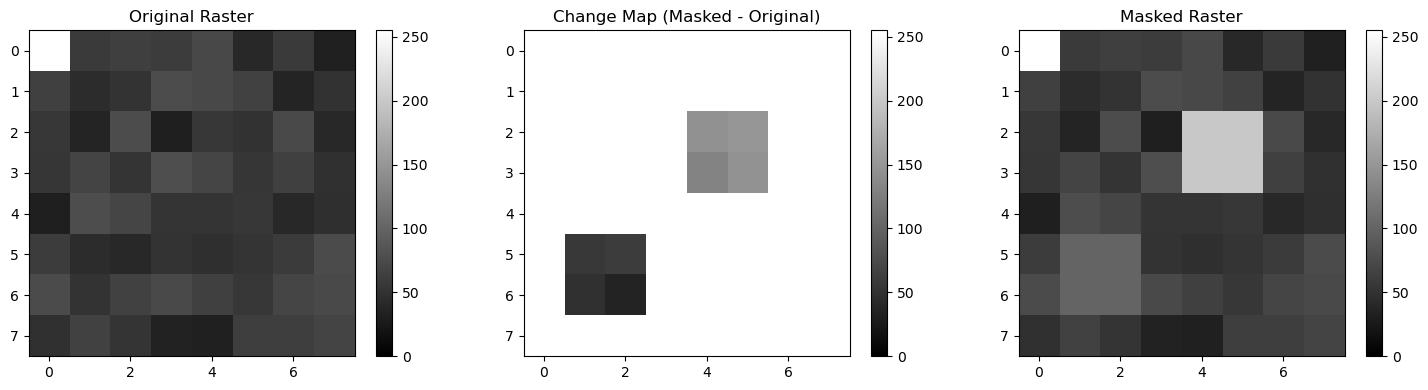

Unique values in original raster: [ 31  32  33  34  37  40  41  44  47  48  50  51  52  53  54  55  58  59
  60  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78 255]
Unique values in masked raster: [ 31  32  33  34  37  40  41  44  47  48  50  51  52  53  54  55  58  59
  60  61  62  63  64  65  66  68  69  72  73  74  75  76  77  78 100 200
 255]
Unique changes: [ 35  49  56  60 131 145 146 150]


In [5]:
# Function 4: apply_masking

# --- Setup paths ---
raster_path = "test_data/fun_4/test_raster.tif"
output_path = "test_data/fun_4/test_output/test_masked.tif"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# --- Create GeoDataFrame with mask values ---
gdf = gpd.GeoDataFrame(
    {
        "mask_val": [100, 200],
        "geometry": [
            box(1, 1, 3, 3),  # square 1
            box(4, 4, 6, 6)   # square 2
        ]
    },
    crs="EPSG:4326"
)

# --- Create dummy raster with random grayscale values ---
width, height = 8, 8
transform = rasterio.transform.from_origin(0, 8, 1, 1)

np.random.seed(42)
initial_data = np.random.randint(30, 80, size=(height, width), dtype=np.uint8)
initial_data[0, 0] = 255  # mark top-left corner as NoData

meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "uint8",             # 8-bit grayscale
    "crs": "EPSG:4326",
    "transform": transform,
    "nodata": 255
}

# Save initial raster
with rasterio.open(raster_path, "w", **meta) as dst:
    dst.write(initial_data, 1)

# --- Save a copy of original for comparison ---
with rasterio.open(raster_path) as src:
    original = src.read(1)

# --- Apply masking ---
apply_masking(gdf, raster_path, "mask_val", output_path)

# --- Load output ---
with rasterio.open(output_path) as src:
    masked = src.read(1)

# --- Compute difference map ---
diff = masked.astype(int) - original.astype(int)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Original
im0 = axes[0].imshow(original, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Original Raster")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Plot 2: Difference (black background, red where changed)
masked_diff = np.where(diff != 0, diff, np.nan)  # keep background black
im1 = axes[1].imshow(masked_diff, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Change Map (Masked - Original)")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Plot 3: Masked output
im2 = axes[2].imshow(masked, cmap="gray", vmin=0, vmax=255)
axes[2].set_title("Masked Raster")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

# --- Print pixel stats ---
print("Unique values in original raster:", np.unique(original))
print("Unique values in masked raster:", np.unique(masked))
print("Unique changes:", np.unique(diff[diff != 0]))

Detected 0 NoData pixels in input raster.
Applying masking for attribute 'IMD' on raster IMD.tif with value 0.9
Masking complete: output saved to IMD_mask.tif.
No explicit NoData value defined in the input raster.
Applying masking for attribute 'BH' on raster BH.tif with value 0
Masking complete: output saved to BH_mask.tif.
Detected 39734 NoData pixels in input raster.
Applying masking for attribute 'F_AC' on raster F_AC.tif with value 0.6
Masking complete: output saved to F_AC_mask.tif.
Detected 39734 NoData pixels in input raster.
Applying masking for attribute 'F_BS' on raster F_BS.tif with value 0.1
Masking complete: output saved to F_BS_mask.tif.


/opt/anaconda3/envs/geo/lib/python3.10/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


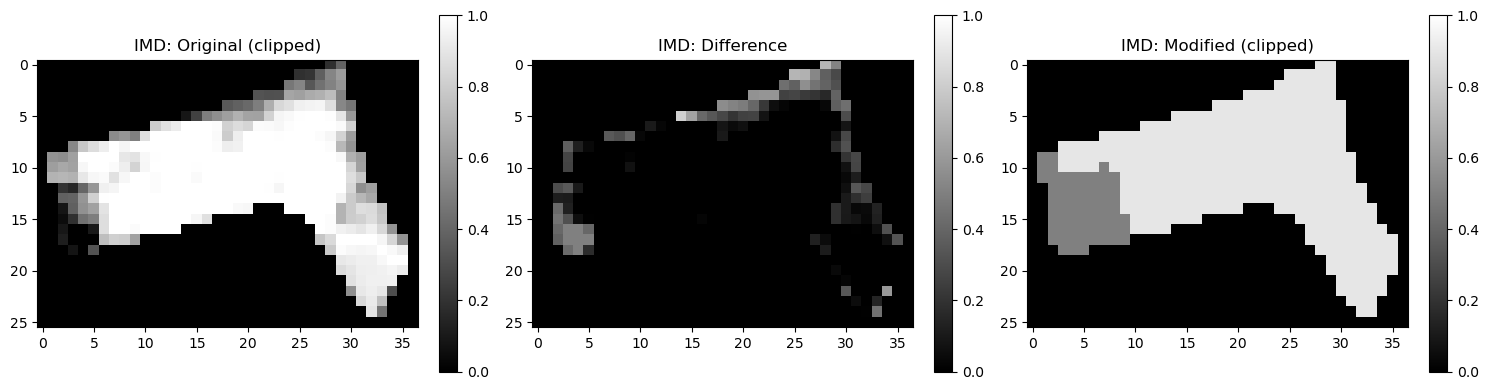

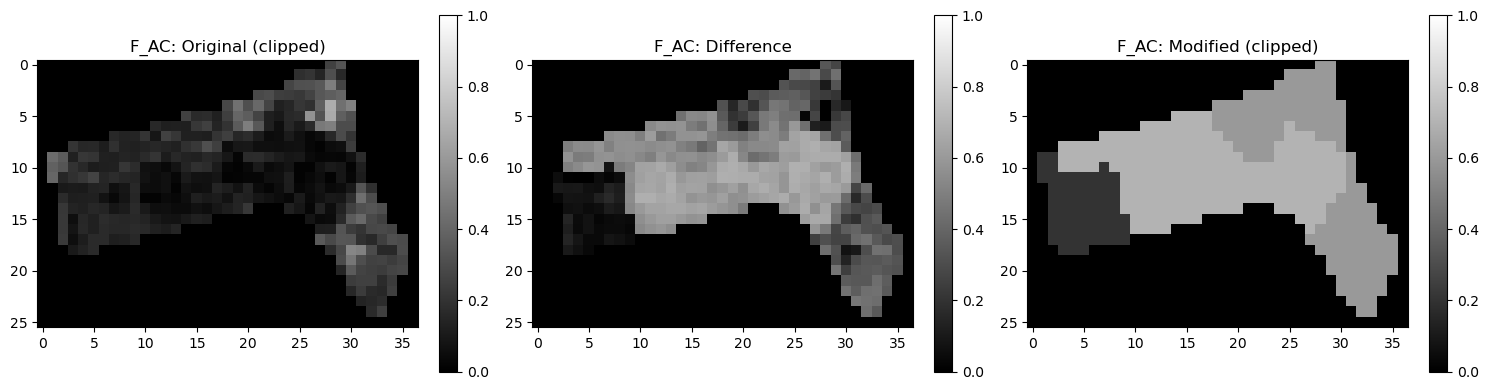

In [26]:
# Function 5: apply_mask_rule_all

# Paths
ucp_folder = "test_data/fun_5/ucps"
fractions_folder = "test_data/fun_5/lc_fractions"
output_folder = "test_data/fun_5/output"
vector_path = "test_data/fun_5/test_mask.geojson"
rules_path = "test_data/fun_5/operation_rules_C1.json"

os.makedirs(output_folder, exist_ok=True)
gdf = gpd.read_file(vector_path)

with open(rules_path, "r") as f:
    rules = json.load(f)

apply_mask_rule_all(gdf, rules, ucp_folder, fractions_folder, output_folder)

def load_and_clip_raster(raster_path, gdf):
    with rasterio.open(raster_path) as src:
        clipped, _ = mask(src, gdf.geometry, crop=True)
        return clipped[0]

def plot_clipped_comparison(raster_name, original_path, masked_path, gdf, vmin=0, vmax=1):
    before = load_and_clip_raster(original_path, gdf)
    after = load_and_clip_raster(masked_path, gdf)
    diff = after - before

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].imshow(before, cmap="gray", vmin=0, vmax=1)
    axes[0].set_title(f"{raster_name}: Original (clipped)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[2].imshow(after, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title(f"{raster_name}: Modified (clipped)")
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    im2 = axes[1].imshow(diff, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title(f"{raster_name}: Difference")
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

plot_clipped_comparison("IMD", f"{ucp_folder}/IMD.tif", f"{output_folder}/IMD_mask.tif", gdf)
plot_clipped_comparison("F_AC", f"{fractions_folder}/F_AC.tif", f"{output_folder}/F_AC_mask.tif", gdf)

In [27]:
# Function 6: is_fraction_layer

def test_is_fraction_layer():
    # Test cases expected to return True
    assert is_fraction_layer("F_AC") == True
    assert is_fraction_layer("F_SOIL") == True
    assert is_fraction_layer("F_COVER.tif") == True

    # Test cases expected to return False
    assert is_fraction_layer("IMD") == False
    assert is_fraction_layer("BSF.tif") == False
    assert is_fraction_layer("cover_F_") == False
    assert is_fraction_layer("") == False
    assert is_fraction_layer(".tif") == False
    assert is_fraction_layer("f_lowercase") == False  # case-sensitive

    print("✅ All tests passed for is_fraction_layer()")

# Run the test
test_is_fraction_layer()

✅ All tests passed for is_fraction_layer()


/opt/anaconda3/envs/geo/lib/python3.10/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


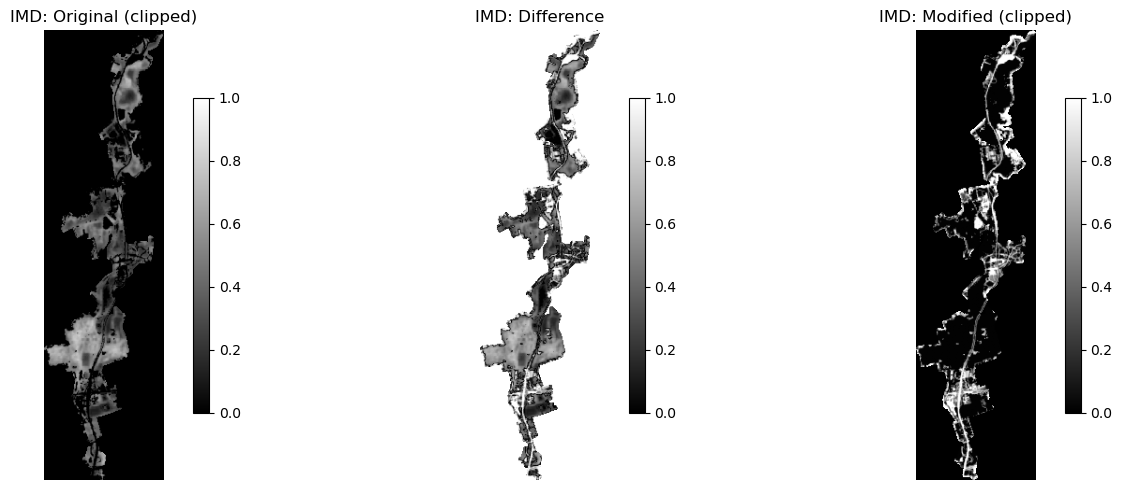

In [31]:
# Function 7:apply_pct_ucp

# --- Paths ---
vector_path = "test_data/fun_7/vector_pct.geojson"
raster_path = "test_data/fun_7/ucps/TCH.tif"
output_path = "test_data/fun_7/output/TCH_pct.tif"

# --- Load Vector and Calculate Bounds for Cropping ---
gdf = gpd.read_file(vector_path)
bounds_geom = [g.__geo_interface__ for g in gdf.geometry]

# --- Load and Clip Rasters ---
def load_and_clip(path, shapes):
    with rasterio.open(path) as src:
        clipped, _ = mask(src, shapes=shapes, crop=True)
    return clipped[0]

# Load clipped arrays
original = load_and_clip(raster_path, bounds_geom)
modified = load_and_clip(output_path, bounds_geom)
difference = np.abs(modified - original)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Horizontal layout

# Original
im0 = axes[0].imshow(original, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("IMD: Original (clipped)")
fig.colorbar(im0, ax=axes[0], shrink=0.7)

# Modified
im1 = axes[2].imshow(modified, cmap="gray", vmin=0, vmax=1)
axes[2].set_title("IMD: Modified (clipped)")
fig.colorbar(im1, ax=axes[1], shrink=0.7)

# Difference
im2 = axes[1].imshow(difference, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("IMD: Difference")
fig.colorbar(im2, ax=axes[2], shrink=0.7)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

F_AC pct -40 0.6
F_S pct 20 1.2
F_M pct 10 1.1
F_BS pct -50 0.5
F_G pct -60 0.4
F_TV pct 30 1.3
F_W pct 40 1.4
Pixel sum stats: 0.99999976 1.0000002 1.0
Finished applying percentage changes and polygon-wise normalization to fraction layers.


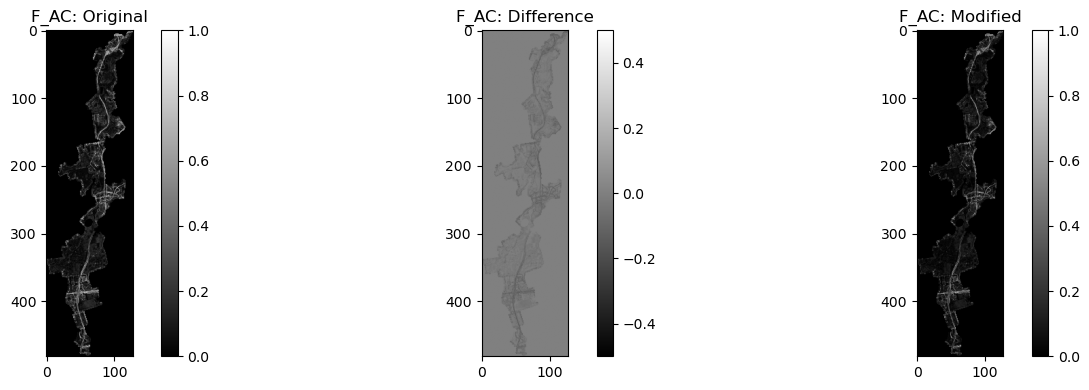

F_AC - Modified pixel stats: min=-1.000, max=0.750, mean=-0.676


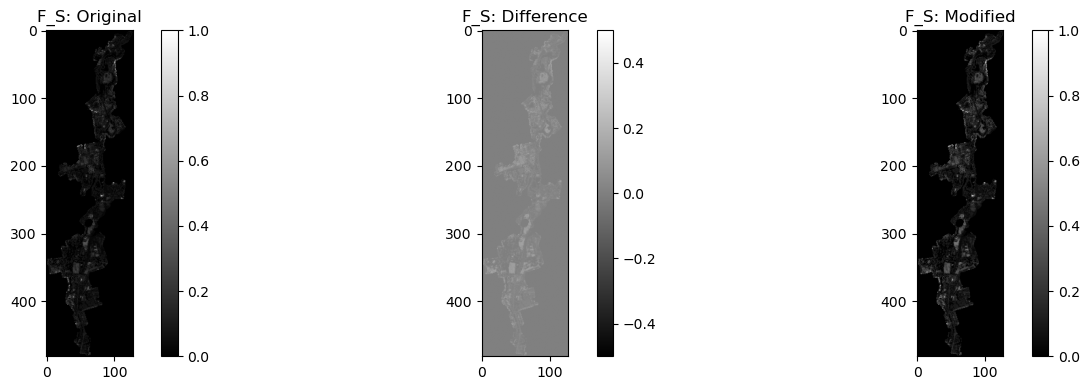

F_S - Modified pixel stats: min=-1.000, max=0.879, mean=-0.676


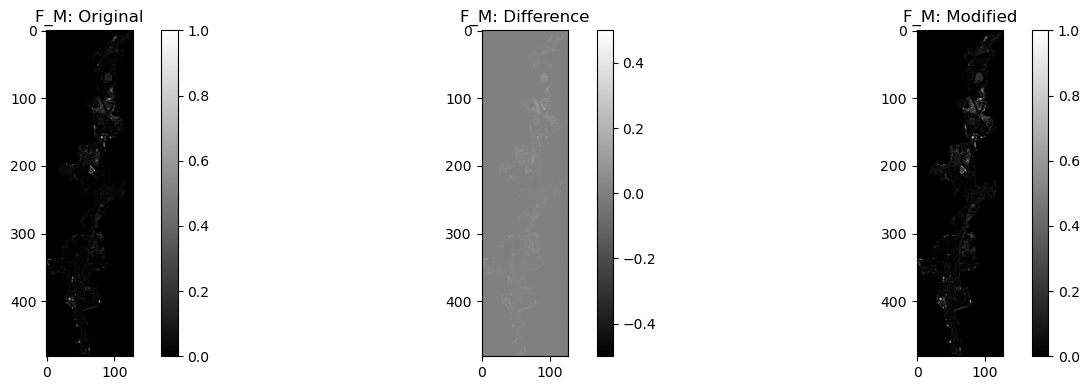

F_M - Modified pixel stats: min=-1.000, max=0.895, mean=-0.692


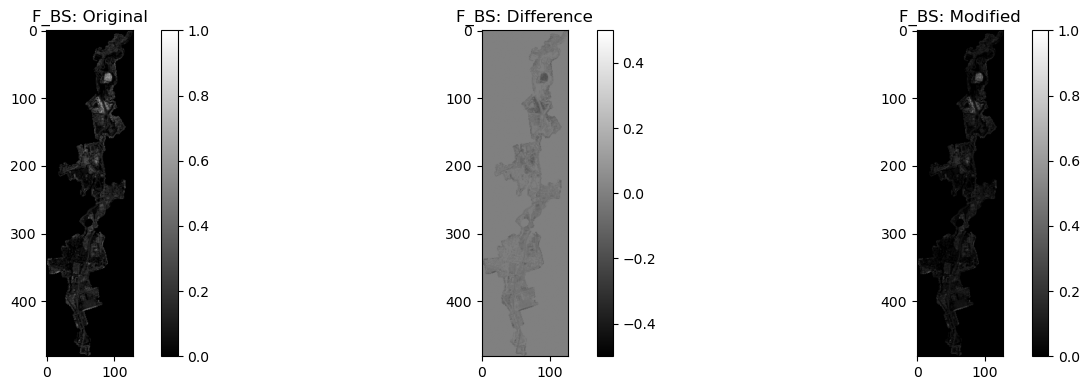

F_BS - Modified pixel stats: min=-1.000, max=0.552, mean=-0.689


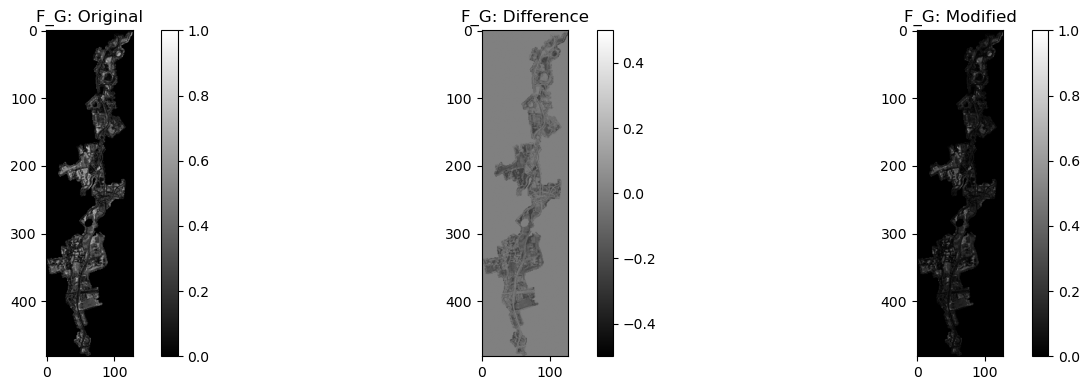

F_G - Modified pixel stats: min=-1.000, max=0.732, mean=-0.679


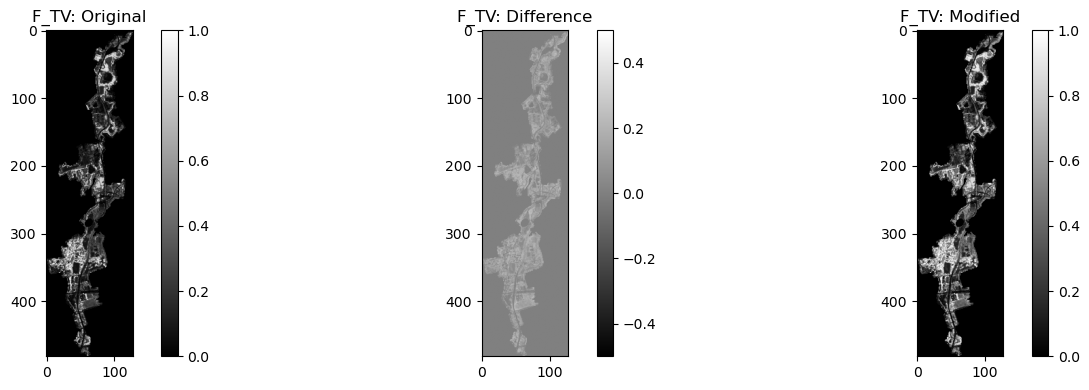

F_TV - Modified pixel stats: min=-1.000, max=0.981, mean=-0.600


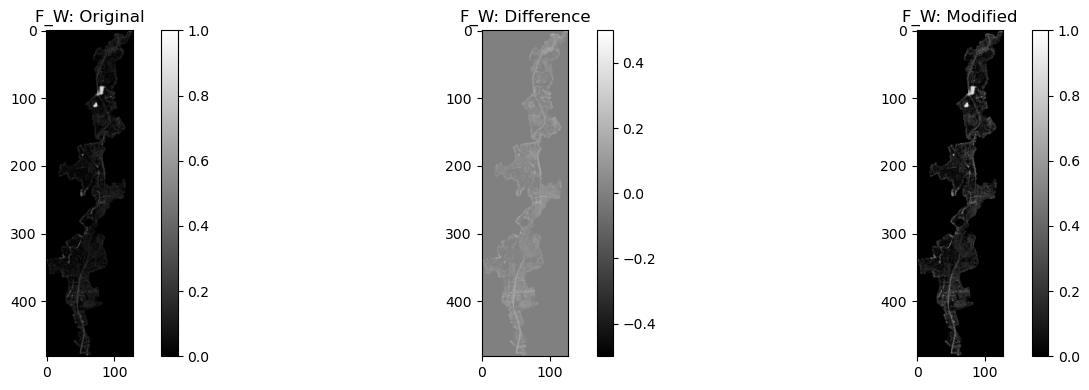

F_W - Modified pixel stats: min=-1.000, max=0.946, mean=-0.669


In [45]:
# Function 8: apply_pct_all_fractions

# --- Paths ---
base_path = "test_data/fun_8"
vector_path = os.path.join(base_path, "vector_pct.geojson")
rules_path = os.path.join(base_path, "operation_rules_C2.json")
fractions_folder = os.path.join(base_path, "lc_fractions")
output_folder = os.path.join(base_path, "output")

os.makedirs(output_folder, exist_ok=True)

# --- Load data ---
gdf = gpd.read_file(vector_path)
with open(rules_path, "r") as f:
    rules = json.load(f)

# --- Run the function ---
apply_pct_all_fractions(gdf, rules, fractions_folder, output_folder)

# --- Helper: clip raster to gdf ---
def clip_raster(raster_path, gdf):
    with rasterio.open(raster_path) as src:
        arr, _ = mask(src, gdf.geometry, crop=True)
    return arr[0]

def show_raster_diff(name, original_path, modified_path):
    orig = clip_raster(original_path, gdf)
    mod = clip_raster(modified_path, gdf)
    diff = mod - orig

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axes[0].imshow(orig, cmap="gray", vmin=0, vmax=1)
    axes[0].set_title(f"{name}: Original")
    plt.colorbar(im0, ax=axes[0], fraction=0.046)

    im1 = axes[1].imshow(diff, cmap="gray", vmin=-0.5, vmax=0.5)
    axes[1].set_title(f"{name}: Difference")
    plt.colorbar(im1, ax=axes[1], fraction=0.046)

    im2 = axes[2].imshow(mod, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title(f"{name}: Modified")
    plt.colorbar(im2, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

    # Validation info
    print(f"{name} - Modified pixel stats: min={mod.min():.3f}, max={mod.max():.3f}, mean={mod.mean():.3f}")

# --- Run visualization for each fraction layer ---
for fname in rules:
    if not fname.startswith("F_") or rules[fname] != "pct":
        continue

    original_path = os.path.join(fractions_folder, fname)
    modified_path = os.path.join(output_folder, fname.replace(".tif", "_pct.tif"))
    if os.path.exists(modified_path):
        show_raster_diff(fname.replace(".tif", ""), original_path, modified_path)
    else:
        print(f"Missing modified raster: {modified_path}")

F_AC none 0.0 1.0
F_S pct 20 1.2
F_M none 0.0 1.0
F_BS pct -50 0.5
F_G pct -60 0.4
F_TV pct 30 1.3
F_W none 0.0 1.0
Pixel sum stats: 0.99999976 1.0000002 1.0
Finished applying percentage changes and polygon-wise normalization to fraction layers.
No explicit NoData value defined in the input raster.
TCH pct 60 1.6
IMD none 0.0 1.0
No explicit NoData value defined in the input raster.
BH none 0.0 1.0
BSF none 0.0 1.0
No explicit NoData value defined in the input raster.
SVF none 0.0 1.0
✅ Showing: TCH


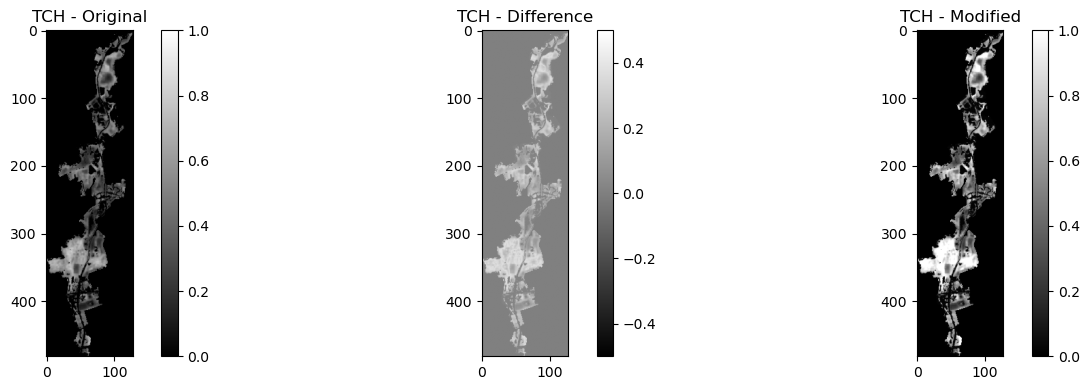

✅ Showing: IMD


/opt/anaconda3/envs/geo/lib/python3.10/site-packages/matplotlib/colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


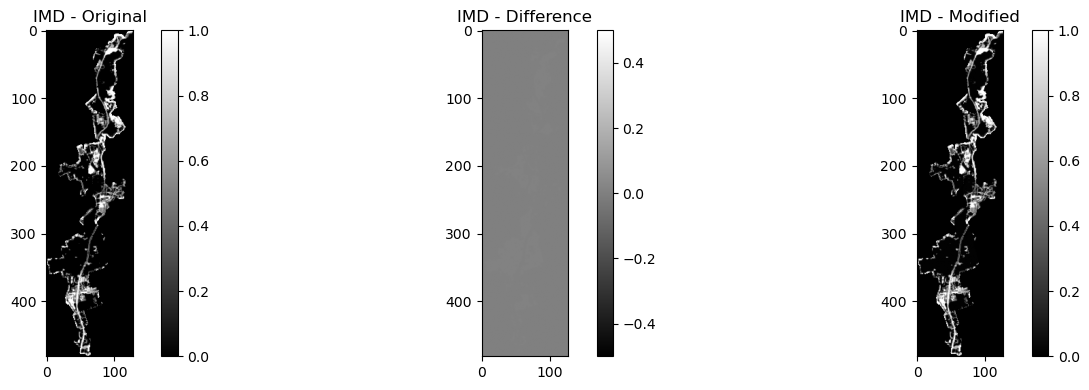

✅ Showing: BH


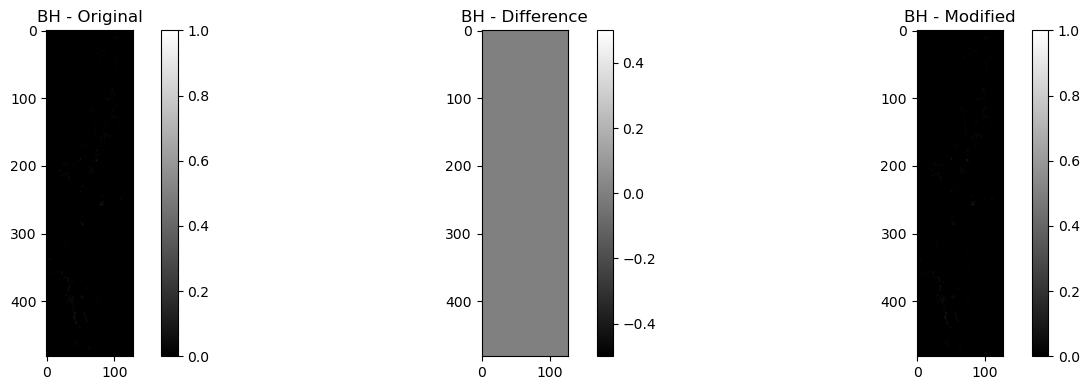

✅ Showing: BSF


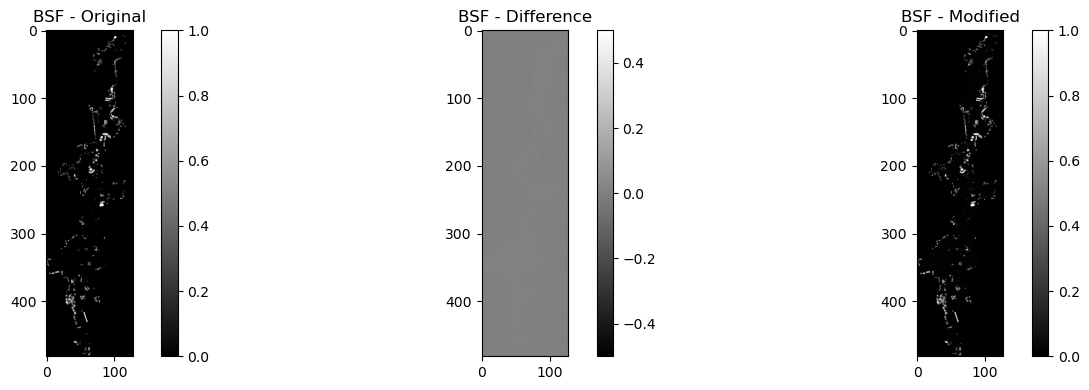

✅ Showing: SVF


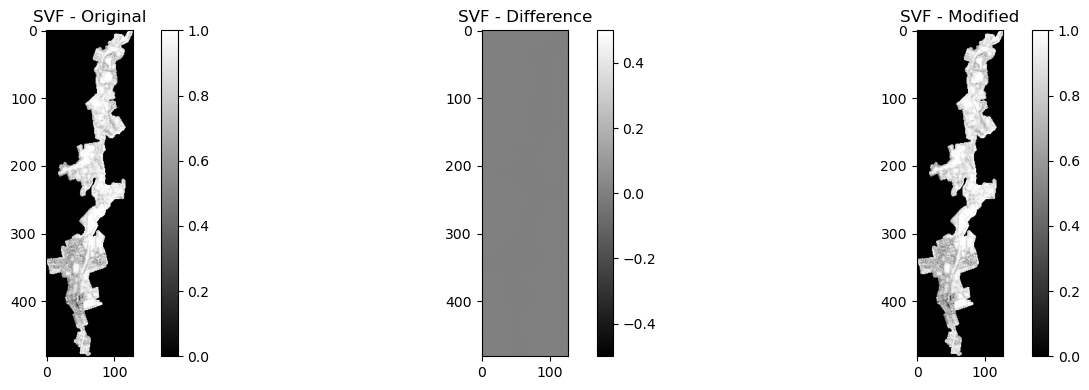

✅ Showing: F_AC


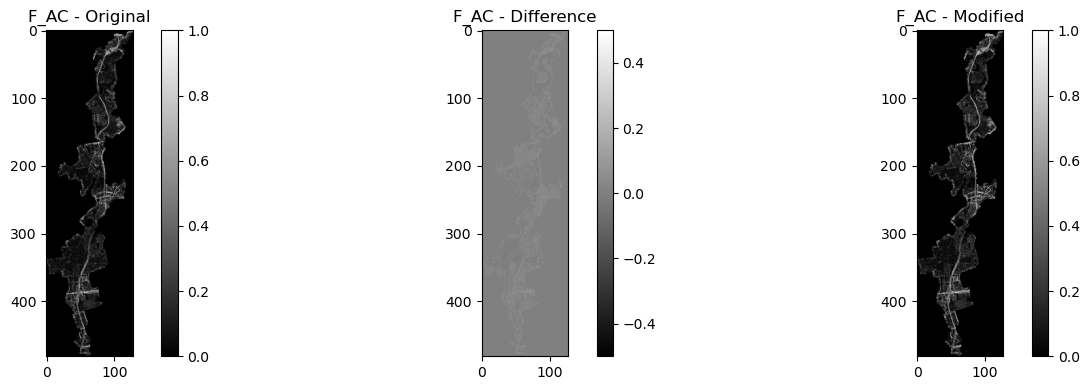

   Sum stats for F_AC (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.844, mean=-0.657
✅ Showing: F_S


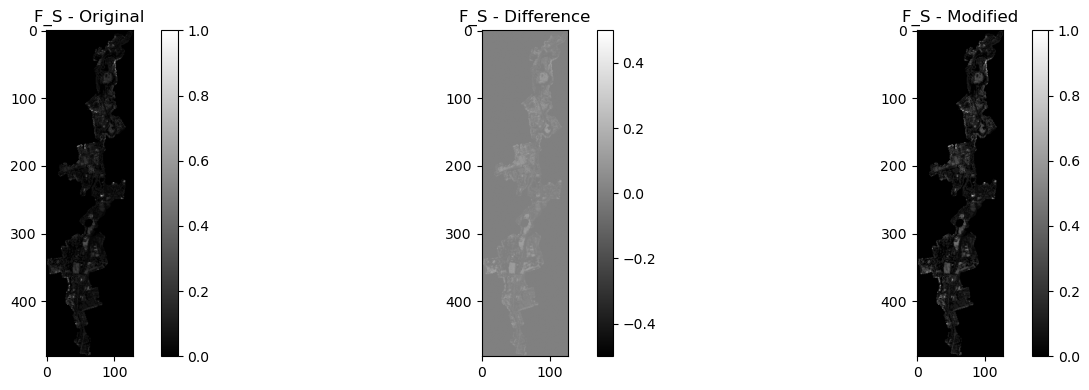

   Sum stats for F_S (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.874, mean=-0.677
✅ Showing: F_M


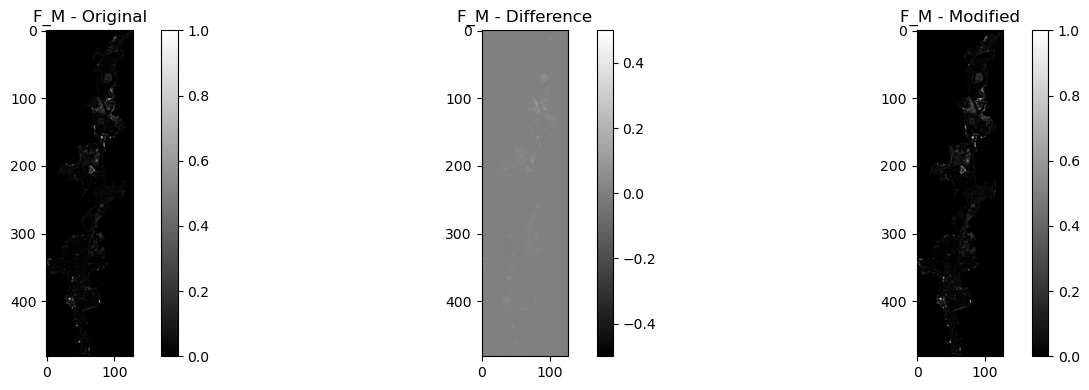

   Sum stats for F_M (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.889, mean=-0.694
✅ Showing: F_BS


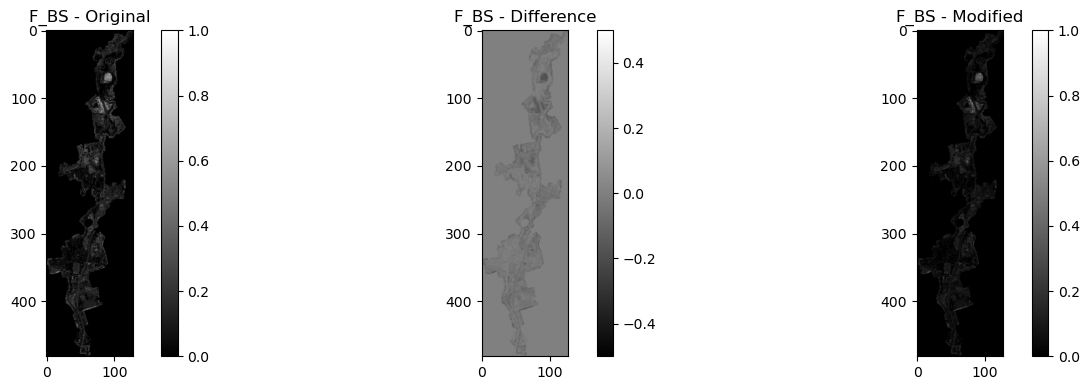

   Sum stats for F_BS (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.541, mean=-0.690
✅ Showing: F_G


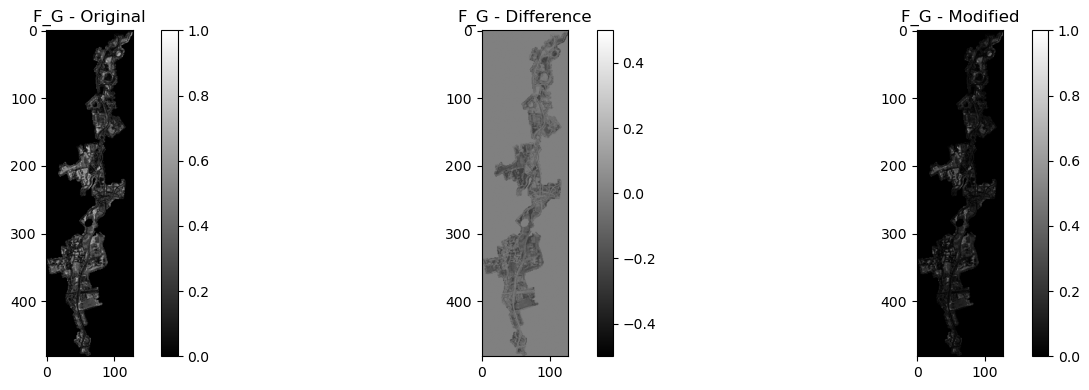

   Sum stats for F_G (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.741, mean=-0.679
✅ Showing: F_TV


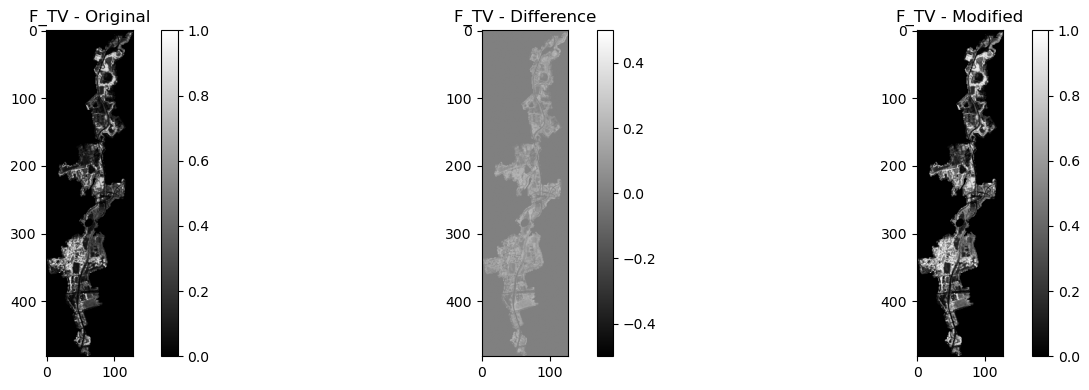

   Sum stats for F_TV (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.981, mean=-0.601
✅ Showing: F_W


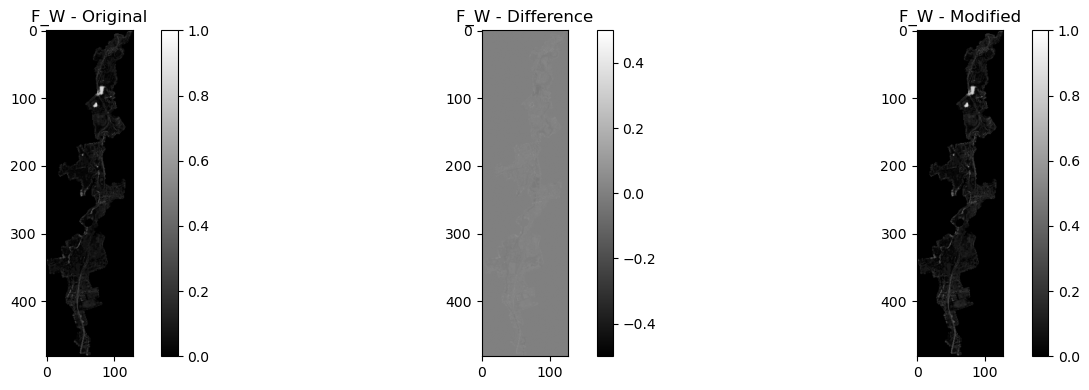

   Sum stats for F_W (should be ~1 when combined across layers)
   Range: min=-1.000, max=0.915, mean=-0.681


In [46]:
# Function 9: apply_pct_all

# --- Paths ---
base = "test_data/fun_9"
vector_path = os.path.join(base, "vector_pct.geojson")
rules_path = os.path.join(base, "operation_rules_C3.json")
ucp_folder = os.path.join(base, "ucps")
fractions_folder = os.path.join(base, "lc_fractions")
output_folder = os.path.join(base, "output")
os.makedirs(output_folder, exist_ok=True)

# --- Load data ---
gdf = gpd.read_file(vector_path)
with open(rules_path, "r") as f:
    rules = json.load(f)

# --- Run the full percentage adjustment ---
apply_pct_all(gdf, rules, ucp_folder, fractions_folder, output_folder)

# --- Helper to clip rasters ---
def clip_raster(path, gdf):
    with rasterio.open(path) as src:
        out_img, _ = mask(src, gdf.geometry, crop=True)
    return out_img[0]

# --- Plot side-by-side original/difference/modified ---
def visualize_change(name, orig_path, mod_path, diff_vrange=(-0.5, 0.5), clip=(0, 1)):
    orig = clip_raster(orig_path, gdf)
    mod = clip_raster(mod_path, gdf)
    diff = mod - orig

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axs[0].imshow(orig, cmap="gray", vmin=clip[0], vmax=clip[1])
    axs[0].set_title(f"{name} - Original")
    plt.colorbar(im0, ax=axs[0], fraction=0.046)

    im1 = axs[1].imshow(diff, cmap="gray", vmin=diff_vrange[0], vmax=diff_vrange[1])
    axs[1].set_title(f"{name} - Difference")
    plt.colorbar(im1, ax=axs[1], fraction=0.046)

    im2 = axs[2].imshow(mod, cmap="gray", vmin=clip[0], vmax=clip[1])
    axs[2].set_title(f"{name} - Modified")
    plt.colorbar(im2, ax=axs[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

# --- Visualize all outputs ---
for layer in rules:
    rule = rules[layer]
    base_name = layer.replace(".tif", "")
    is_fraction = base_name.startswith("F_")
    modified_path = os.path.join(output_folder, base_name + "_pct.tif")
    original_path = os.path.join(fractions_folder if is_fraction else ucp_folder, layer)

    if not os.path.exists(modified_path):
        print(f"❌ Missing output: {modified_path}")
        continue

    print(f"✅ Showing: {base_name}")
    visualize_change(base_name, original_path, modified_path)

    if is_fraction:
        mod = clip_raster(modified_path, gdf)
        print(f"   Sum stats for {base_name} (should be ~1 when combined across layers)")
        print(f"   Range: min={mod.min():.3f}, max={mod.max():.3f}, mean={mod.mean():.3f}")

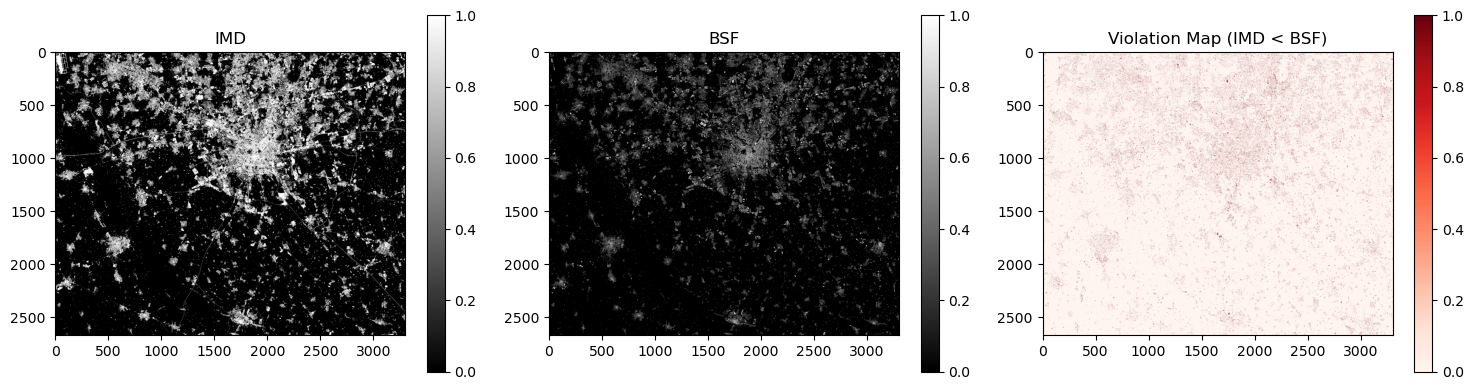

In [47]:
# Function 10: check_imd_bsf_consistency

# --- Define test folder ---
output_folder = "test_data/fun_10/output"
imd_path = os.path.join(output_folder, "IMD_pct.tif")
bsf_path = os.path.join(output_folder, "BSF_pct.tif")

# --- Run the check ---
check_imd_bsf_consistency(output_folder)

# --- Optional: Visualize where IMD < BSF ---
def visualize_imd_bsf_violations(imd_path, bsf_path):
    with rasterio.open(imd_path) as src_imd, rasterio.open(bsf_path) as src_bsf:
        imd = src_imd.read(1)
        bsf = src_bsf.read(1)

    # Identify violations
    invalid = (imd < bsf) & (~np.isnan(imd)) & (~np.isnan(bsf))

    if not np.any(invalid):
        print("✅ No violations to visualize.")
        return

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    im0 = axs[0].imshow(imd, cmap="gray", vmin=0, vmax=1)
    axs[0].set_title("IMD")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(bsf, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("BSF")
    plt.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(invalid, cmap="Reds")
    axs[2].set_title("Violation Map (IMD < BSF)")
    plt.colorbar(im2, ax=axs[2])

    plt.tight_layout()
    plt.show()

# --- Visual inspection ---
visualize_imd_bsf_violations(imd_path, bsf_path)